In [1]:
import findspark
import pyspark as ps
import warnings
from pyspark.sql import SQLContext

import matplotlib.pyplot as plt

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import string

from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

from pyspark.ml.feature import HashingTF, IDF, Tokenizer, StopWordsRemover, StringIndexer, VectorIndexer
from pyspark.ml import Pipeline

from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.classification import LogisticRegression, NaiveBayes, GBTClassifier

from nltk.stem.snowball import SnowballStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import pandas as pd

%matplotlib inline

In [2]:
#Creating SparkContext on all CPUs available
try:
    sc = ps.SparkContext('local[1]')
    sqlContext = SQLContext(sc)
    print("Just created a SparkContext")
except ValueError:
    warnings.warn("SparkContext already exists in this scope")

Just created a SparkContext


In [3]:
sc.master

'local[1]'

In [4]:
#Reading Yelp Business Json file
business_json = sqlContext.read.json("D:/yelp-dataset/yelp_academic_dataset_business.json")

In [48]:
#Records in the file
business_json.count()

209393

In [5]:
#Removing missing data from the dataset
business_json = business_json.dropna()
business_json.count()

146796

In [50]:
business_json.printSchema()

root
 |-- address: string (nullable = true)
 |-- attributes: struct (nullable = true)
 |    |-- AcceptsInsurance: string (nullable = true)
 |    |-- AgesAllowed: string (nullable = true)
 |    |-- Alcohol: string (nullable = true)
 |    |-- Ambience: string (nullable = true)
 |    |-- BYOB: string (nullable = true)
 |    |-- BYOBCorkage: string (nullable = true)
 |    |-- BestNights: string (nullable = true)
 |    |-- BikeParking: string (nullable = true)
 |    |-- BusinessAcceptsBitcoin: string (nullable = true)
 |    |-- BusinessAcceptsCreditCards: string (nullable = true)
 |    |-- BusinessParking: string (nullable = true)
 |    |-- ByAppointmentOnly: string (nullable = true)
 |    |-- Caters: string (nullable = true)
 |    |-- CoatCheck: string (nullable = true)
 |    |-- Corkage: string (nullable = true)
 |    |-- DietaryRestrictions: string (nullable = true)
 |    |-- DogsAllowed: string (nullable = true)
 |    |-- DriveThru: string (nullable = true)
 |    |-- GoodForDancing: str

In [6]:
#Function to fetch only business related to Medical
@udf("string")
def business_category(categories):
    category = ['Hospitals', 'Doctors', 'Rehabilitation Center', 'Medical Centers', 'Health & Medical']
    for word in category:
        if word in categories:
            return "yes"
        else:
            return "no"

businessID = business_json.withColumn("Flag",business_category(business_json["categories"])).select('Flag', 'business_id', \
                                                                                                    'categories')

businessData = businessID.filter(businessID.Flag == "yes")
businessData.count()

276

In [7]:
#Reading Yelp Review Json file
review_json = sqlContext.read.json("D:/yelp-dataset/yelp_academic_dataset_review.json")

In [53]:
#Records in the file
review_json.count()

8021122

In [54]:
review_json.printSchema()

root
 |-- business_id: string (nullable = true)
 |-- cool: long (nullable = true)
 |-- date: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- review_id: string (nullable = true)
 |-- stars: double (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)



In [8]:
#Filtering reviews only related to medical business
reviewData = review_json.join(businessData, ["business_id", "business_id"], "inner").select("business_id", "user_id", "stars", "useful", "text")

In [9]:
#Total number reiews related to medical business
reviewData.count()

13676

In [9]:
#Converting Stars & Useful to Integer Type
from pyspark.sql.types import IntegerType
reviewData = reviewData.withColumn("Stars", reviewData["Stars"].cast(IntegerType()))
reviewData = reviewData.withColumn("useful", reviewData["useful"].cast(IntegerType()))

In [11]:
reviewData.printSchema()

root
 |-- business_id: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- Stars: integer (nullable = true)
 |-- useful: integer (nullable = true)
 |-- text: string (nullable = true)



In [12]:
reviewData.show(1)

+--------------------+--------------------+-----+------+--------------------+
|         business_id|             user_id|Stars|useful|                text|
+--------------------+--------------------+-----+------+--------------------+
|-_G-VYIWq5ITVcQz4...|3ajn7OsVwsgKqBGGl...|    1|     6|The one time I ca...|
+--------------------+--------------------+-----+------+--------------------+
only showing top 1 row



# Visualising Data

In [63]:
#Calculating the count of score
score_count = reviewData.groupBy("stars").count()
score_count.show()

+-----+-----+
|stars|count|
+-----+-----+
|    1| 6141|
|    3|  622|
|    5| 4799|
|    4| 1163|
|    2|  951|
+-----+-----+



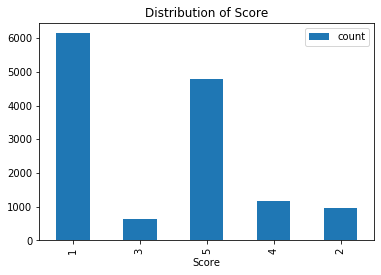

In [64]:
#Ploting Distribution of Score
score_count.toPandas().plot(kind = 'bar', x = 'stars', y = 'count')
plt.title('Distribution of Score')
plt.xlabel('Score')
plt.show()

In [65]:
#Calculating the count of score
useful_count = reviewData.groupBy("useful").count()
useful_count.show()

+------+-----+
|useful|count|
+------+-----+
|    31|    5|
|    78|    1|
|    34|    7|
|    28|    7|
|    26|    8|
|    27|    4|
|    44|    1|
|   253|    1|
|    12|   77|
|    22|   23|
|    47|    1|
|     1| 2767|
|    13|   77|
|     6|  453|
|    16|   39|
|     3| 1179|
|   142|    1|
|    20|   16|
|    40|    1|
|    57|    3|
+------+-----+
only showing top 20 rows



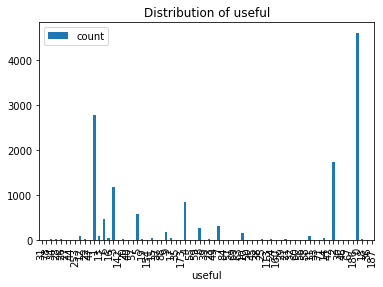

In [66]:
#Ploting the Distribution of useful
useful_count.toPandas().plot(kind = 'bar', x = 'useful', y = 'count')
plt.title('Distribution of useful')
plt.xlabel('useful')
plt.show()

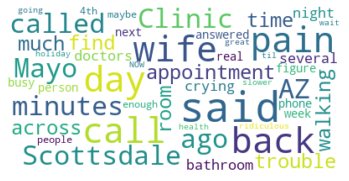

In [16]:
#Creating a word cloud for the reviews
text = reviewData.select('text').collect()
for item in text:
    #print(item[0])
    wordcloud = WordCloud(stopwords = STOPWORDS,  \
                          max_font_size=50,  background_color="white").generate(item[0])

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [10]:
reviews = reviewData.select('Stars', 'useful', 'text')

#Converting score to a binary positive - 1 and negative - 0
@udf("string")
def toBinary(stars):
    if stars >= 3: return 1
    else: return 0
    
reviews = reviews.select("useful", "text", toBinary("stars").alias("Target"))
reviews.show(5)

+------+--------------------+------+
|useful|                text|Target|
+------+--------------------+------+
|     6|The one time I ca...|     0|
|     3|So we were sent h...|     0|
|     0|Tempe St. Luke's ...|     1|
|     3|Amazing care!!! S...|     1|
|     4|My husband and I ...|     1|
+------+--------------------+------+
only showing top 5 rows



In [140]:
#Calculating the count of score
Target_count = reviews.groupBy("Target").count()
Target_count.show()

+------+-----+
|Target|count|
+------+-----+
|    -1| 7092|
|     0|  622|
|     1| 5962|
+------+-----+



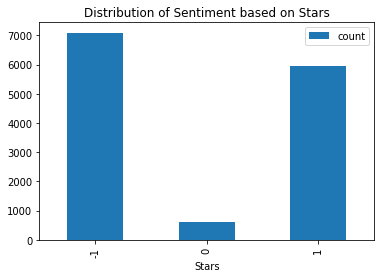

In [144]:
#Ploting the Distribution of Sentiment based on Stars
Target_count.toPandas().plot(kind = 'bar', x = 'Target', y = 'count')
plt.title('Distribution of Sentiment based on Stars')
plt.xlabel('Stars')
plt.show()

# Text Cleaning Process

In [11]:
#Case Normalization
#Lower casing the text
@udf("string")
def lower_text(line):
    return line.lower()

reviews_lower = reviews.select("Target", "useful", lower_text("text").alias("lower_text"))
reviews_lower.show(5)

+------+------+--------------------+
|Target|useful|          lower_text|
+------+------+--------------------+
|     0|     6|the one time i ca...|
|     0|     3|so we were sent h...|
|     1|     0|tempe st. luke's ...|
|     1|     3|amazing care!!! s...|
|     1|     4|my husband and i ...|
+------+------+--------------------+
only showing top 5 rows



In [12]:
#Tokenizing the document
tokenizer = Tokenizer(inputCol="lower_text", outputCol="words")
wordsDataFrame = tokenizer.transform(reviews_lower)
wordsDataFrame.show(5)

+------+------+--------------------+--------------------+
|Target|useful|          lower_text|               words|
+------+------+--------------------+--------------------+
|     0|     6|the one time i ca...|[the, one, time, ...|
|     0|     3|so we were sent h...|[so, we, were, se...|
|     1|     0|tempe st. luke's ...|[tempe, st., luke...|
|     1|     3|amazing care!!! s...|[amazing, care!!!...|
|     1|     4|my husband and i ...|[my, husband, and...|
+------+------+--------------------+--------------------+
only showing top 5 rows



In [13]:
#Removing Stopwords from text
remove_stopWords = StopWordsRemover(inputCol="words", outputCol="words_filtered")
wordsDataFrame = remove_stopWords.transform(wordsDataFrame).select("Target", "useful", "words_filtered")
wordsDataFrame.show(5)

+------+------+--------------------+
|Target|useful|      words_filtered|
+------+------+--------------------+
|     0|     6|[one, time, came,...|
|     0|     3|[sent, urgent, ca...|
|     1|     0|[tempe, st., luke...|
|     1|     3|[amazing, care!!!...|
|     1|     4|[husband, brought...|
+------+------+--------------------+
only showing top 5 rows



In [14]:
#Removing Punctuations from text
@udf("string")
def removePunctuations(x):
    list_punct=list(string.punctuation)
    filtered = [''.join(c for c in s if c not in list_punct) for s in x] 
    filtered_space = [s for s in filtered if s] #remove empty space 
    return filtered

wordsDataFrame = wordsDataFrame.select("Target", "useful", removePunctuations("words_filtered").alias("words_without_Punc"))
wordsDataFrame.show(5)

+------+------+--------------------+
|Target|useful|  words_without_Punc|
+------+------+--------------------+
|     0|     6|[one, time, came,...|
|     0|     3|[sent, urgent, ca...|
|     1|     0|[tempe, st, lukes...|
|     1|     3|[amazing, care, h...|
|     1|     4|[husband, brought...|
+------+------+--------------------+
only showing top 5 rows



In [15]:
#Stemming the text
stemmer = SnowballStemmer(language='english')
stemmer_udf = udf(lambda tokens: [stemmer.stem(token) for token in tokens], StringType())
wordsDataFrame1 = wordsDataFrame.withColumn("final_reviews", stemmer_udf("words_without_Punc"))\
                     .select('Target', 'useful', 'final_reviews')
wordsDataFrame1.show(5)

+------+------+--------------------+
|Target|useful|       final_reviews|
+------+------+--------------------+
|     0|     6|[one, time, came,...|
|     0|     3|[sent, urgent, ca...|
|     1|     0|[temp, st, luke, ...|
|     1|     3|[amaz, care, happ...|
|     1|     4|[husband, brought...|
+------+------+--------------------+
only showing top 5 rows



In [16]:
#Joining back the texts for analysis
@udf("string")
def joinTokens(x):
    joinedTokens_list = []
    x = " ".join(x)
    return x

finalReviewsDf = wordsDataFrame1.select("Target", "useful", joinTokens("final_reviews").alias("final_text"))
finalReviewsDf.show(1)

+------+------+--------------------+
|Target|useful|          final_text|
+------+------+--------------------+
|     0|     6|one time came mys...|
+------+------+--------------------+
only showing top 1 row



In [17]:
#Spliting data into Train, and Test set

(train_set, test_set) = finalReviewsDf.randomSplit([0.80, 0.20], seed = 2000)

# HashingTF, IDF and Logistic Regression Model

In [82]:
#Creating pipeline for HashingTF, IDF
tokenizer = Tokenizer(inputCol="final_text", outputCol="words")
hashingTF = HashingTF(inputCol=tokenizer.getOutputCol() , outputCol="hashing")
idf = IDF(inputCol=hashingTF.getOutputCol(), outputCol="features")
label_stringIdx = StringIndexer(inputCol = "Target", outputCol = "label")
pipeline = Pipeline(stages=[tokenizer, hashingTF, idf, label_stringIdx])

#Traning the Model
pipelineFit = pipeline.fit(train_set)
train_df = pipelineFit.transform(train_set)
test_df = pipelineFit.transform(test_set)
train_df.show(5)

+------+------+--------------------+--------------------+--------------------+--------------------+-----+
|Target|useful|          final_text|               words|             hashing|            features|label|
+------+------+--------------------+--------------------+--------------------+--------------------+-----+
|     0|     0|angri went st luk...|[angri, went, st,...|(262144,[2192,963...|(262144,[2192,963...|  0.0|
|     0|     0|clerk ask name ca...|[clerk, ask, name...|(262144,[6781,184...|(262144,[6781,184...|  0.0|
|     0|     0|come drug test un...|[come, drug, test...|(262144,[10486,34...|(262144,[10486,34...|  0.0|
|     0|     0|do visit offic  n...|[do, visit, offic...|(262144,[23905,26...|(262144,[23905,26...|  0.0|
|     0|     0|go here went ear ...|[go, here, went, ...|(262144,[13957,35...|(262144,[13957,35...|  0.0|
+------+------+--------------------+--------------------+--------------------+--------------------+-----+
only showing top 5 rows



In [83]:
#Logistic Regression Model
lr = LogisticRegression(maxIter=100)

lrModel = lr.fit(train_df)
predictions = lrModel.transform(test_df)

In [86]:
#Evaluating Logistic accuracy
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
roc_auc = evaluator.evaluate(predictions)

accuracy = predictions.filter(predictions.label == predictions.prediction).count() / float(test_set.count())
print('Accuracy:',accuracy)
print('ROC-AUC:', roc_auc)

Accuracy: 0.9038013964313422
ROC-AUC: 0.9610614567642004


# CountVectorizer + IDF + Logistic Regression

In [90]:
from pyspark.ml.feature import CountVectorizer

tokenizer = Tokenizer(inputCol="final_text", outputCol="words")
cv = CountVectorizer(vocabSize=2**16, inputCol="words", outputCol='cv')
idf = IDF(inputCol='cv', outputCol="features", minDocFreq=5) #minDocFreq: remove sparse terms
label_stringIdx = StringIndexer(inputCol = "Target", outputCol = "label")
lr = LogisticRegression(maxIter=100)
pipeline = Pipeline(stages=[tokenizer, cv, idf, label_stringIdx, lr])

pipelineFit = pipeline.fit(train_set)
predictions = pipelineFit.transform(test_set)
accuracy = predictions.filter(predictions.label == predictions.prediction).count() / float(test_set.count())
roc_auc = evaluator.evaluate(predictions)

print('Accuracy:',accuracy)
print('ROC-AUC:', roc_auc)

Accuracy: 0.908844065166796
ROC-AUC: 0.9614345490786809


# N-gram Implementation

In [92]:
from pyspark.ml.feature import NGram, VectorAssembler

def build_ngrams_wocs(inputCol=["final_text","Target"], n=3):
    tokenizer = [Tokenizer(inputCol="final_text", outputCol="words")]
    ngrams = [
        NGram(n=i, inputCol="words", outputCol="{0}_grams".format(i))
        for i in range(1, n + 1)
    ]

    cv = [
        CountVectorizer(vocabSize=5460,inputCol="{0}_grams".format(i),
            outputCol="{0}_tf".format(i))
        for i in range(1, n + 1)
    ]
    idf = [IDF(inputCol="{0}_tf".format(i), outputCol="{0}_tfidf".format(i), minDocFreq=5) for i in range(1, n + 1)]

    assembler = [VectorAssembler(
        inputCols=["{0}_tfidf".format(i) for i in range(1, n + 1)],
        outputCol="features"
    )]
    label_stringIdx = [StringIndexer(inputCol = "Target", outputCol = "label")]
    lr = [LogisticRegression(maxIter=100)]
    return Pipeline(stages=tokenizer + ngrams + cv + idf+ assembler + label_stringIdx+lr)

In [97]:
ng_pipelineFit = build_ngrams_wocs().fit(train_set)
ng_predictions = ng_pipelineFit.transform(test_set)
ng_accuracy = ng_predictions.filter(ng_predictions.label == ng_predictions.prediction).count() / float(test_set.count())
ng_roc_auc = evaluator.evaluate(ng_predictions)

# print accuracy, roc_auc
print('Accuracy:',ng_accuracy)
print('ROC-AUC:', ng_roc_auc)

Accuracy: 0.9154383242823895
ROC-AUC: 0.9715603840477168


# Navie Bayes

In [98]:
#Creating pipeline for HashingTF, IDF
tokenizer = Tokenizer(inputCol="final_text", outputCol="words")
hashingTF = HashingTF(inputCol=tokenizer.getOutputCol() , outputCol="hashing")
idf = IDF(inputCol=hashingTF.getOutputCol(), outputCol="features")
label_stringIdx = StringIndexer(inputCol = "Target", outputCol = "label")
pipeline = Pipeline(stages=[tokenizer, hashingTF, idf, label_stringIdx])

#Traning the Model
pipelineFit = pipeline.fit(train_set)
train_df = pipelineFit.transform(train_set)
test_df = pipelineFit.transform(test_set)
train_df.show(5)

+------+------+--------------------+--------------------+--------------------+--------------------+-----+
|Target|useful|          final_text|               words|             hashing|            features|label|
+------+------+--------------------+--------------------+--------------------+--------------------+-----+
|     0|     0|angri went st luk...|[angri, went, st,...|(262144,[2192,963...|(262144,[2192,963...|  0.0|
|     0|     0|clerk ask name ca...|[clerk, ask, name...|(262144,[6781,184...|(262144,[6781,184...|  0.0|
|     0|     0|come drug test un...|[come, drug, test...|(262144,[10486,34...|(262144,[10486,34...|  0.0|
|     0|     0|do visit offic  n...|[do, visit, offic...|(262144,[23905,26...|(262144,[23905,26...|  0.0|
|     0|     0|go here went ear ...|[go, here, went, ...|(262144,[13957,35...|(262144,[13957,35...|  0.0|
+------+------+--------------------+--------------------+--------------------+--------------------+-----+
only showing top 5 rows



In [99]:
nb = NaiveBayes(smoothing=1.0, modelType="multinomial")

nbModel = nb.fit(train_df)

predictions = nbModel.transform(test_df)

In [100]:
#Evaluating Navie Bayes accuracy
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction",
                                              metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test set accuracy = " + str(accuracy))

Test set accuracy = 0.8983708301008534


# Sentiment Analysis using VADER

In [18]:
dataframe = finalReviewsDf.toPandas()
dataframe.head(1)

,Target,useful,final_text
0,0,6,one time came myself arizona brown spider bite...


In [19]:
def sentiment_scores(sentence): 
  
    sid_obj = SentimentIntensityAnalyzer() 
    

    sentiment_dict = sid_obj.polarity_scores(sentence) 
  
    if sentiment_dict['compound'] >= 0.5 : 
        return "Positive"
  
    elif sentiment_dict['compound'] <= - 0.5 : 
        return "Negative"
  
    else : 
        return "Neutral"

In [20]:
all_review_df = dataframe.final_text
sentiment_df = all_review_df.apply(sentiment_scores)
analyze_df = pd.DataFrame(pd.concat([all_review_df, sentiment_df], axis = 1))
analyze_df.columns = ["review" , "sentiment"]
analyze_df.head(10)

,review,sentiment
0,one time came myself arizona brown spider bite...,Neutral
1,sent urgent care opt take ambul knowthat expen...,Positive
2,temp st luke look pretti surfac far best er nu...,Positive
3,amaz care happi sent surgeri nurs kind compass...,Positive
4,husband brought son see pediatr urologist pedi...,Positive
5,omg drove way avondal pediatrician said best o...,Positive
6,review audiolog depart realli say enough good ...,Positive
7,sever time one time got mix anoth patient dont...,Negative
8,wait locat ridicul came wait 30 minut first w...,Positive
9,pch great hospit get best care help kid teenan...,Positive


In [28]:
sentiment_count = analyze_df.groupby(analyze_df['sentiment']).count()
sentiment_count

,review
sentiment,
Negative,2448
Neutral,2930
Positive,8298


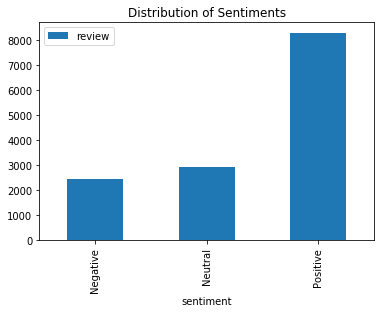

In [32]:
#Plotting the distribution of Sentiments
sentiment_count.plot.bar()
plt.title('Distribution of Sentiments')
plt.show()

Text(0.5, 1.0, 'Sentiment of all reviews')

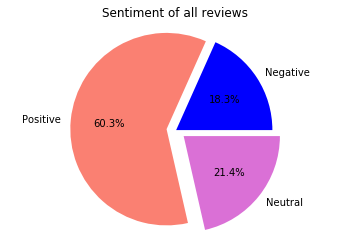

In [105]:
num_neg = analyze_df[analyze_df.sentiment == "Negative"].count().values[1]
num_pos = analyze_df[analyze_df.sentiment == "Positive"].count().values[1]
num_neu = analyze_df[analyze_df.sentiment == "Neutral"].count().values[1]

fig1, ax1 = plt.subplots()
color = ["b" , "salmon", "orchid"]
ax1.pie([num_neg , num_pos , num_neu], explode= (0, 0.1, 0.1) , \
        colors=color , labels = ["Negative", "Positive", "Neutral"] ,autopct='%1.1f%%')
ax1.axis('equal')
plt.title("Sentiment of all reviews")

In [106]:
#Fetching top 100 most common words
from collections import Counter
mostCommonWords = Counter(" ".join(analyze_df["review"]).split()).most_common(100)

In [107]:
#Converting into dataframe
freqDataFrame = pd.DataFrame(list(mostCommonWords), columns=["Words", "Frequency"])

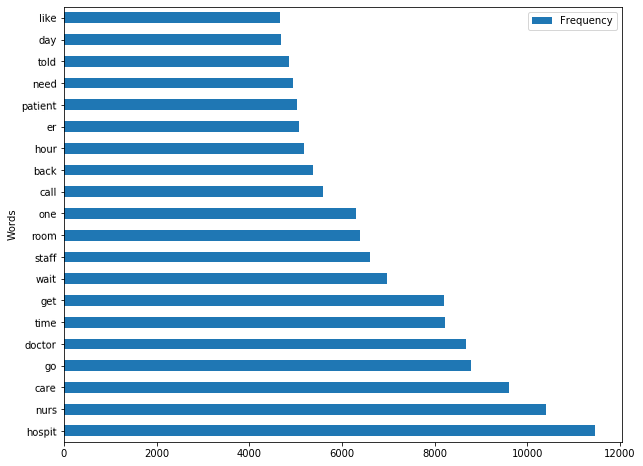

In [108]:
#Ploting horizontal bar graph for the top 20 most common words
freqDataFrame.head(20).plot.barh(x='Words', y='Frequency', rot=1, figsize=(10,8))

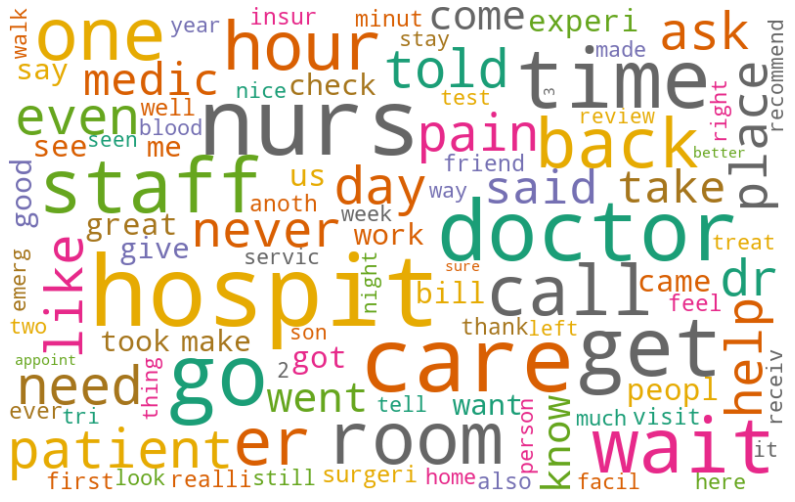

In [109]:
#Creating a word cloud for most common words
wordcloudConvertDF = freqDataFrame.set_index('Words').T.to_dict('records')
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=100, relative_scaling=0.5, colormap='Dark2', background_color='white').generate_from_frequencies(dict(*wordcloudConvertDF))

plt.figure(figsize=(14, 10))    
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [120]:
#Fetching top 100 most common negative words
from collections import Counter

negative_review = analyze_df[analyze_df.sentiment == "Negative"]

mostCommonNegWords = Counter(" ".join(negative_review["review"]).split()).most_common(100)

In [111]:
#Converting into dataframe
negFreqDataFrame = pd.DataFrame(list(mostCommonNegWords), columns=["Words", "Frequency"])

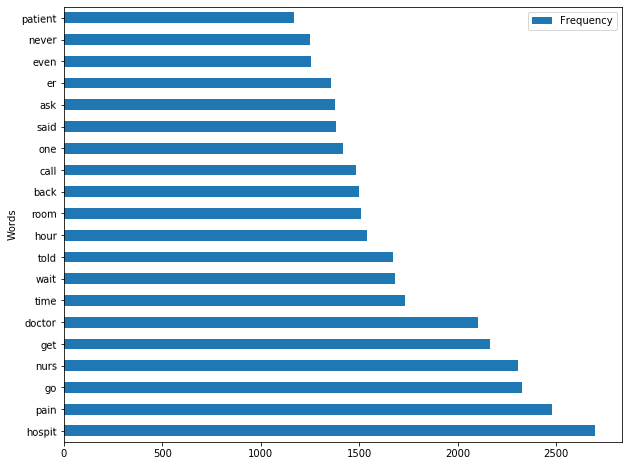

In [112]:
#Ploting horizontal bar graph for the top 20 most common negative words
negFreqDataFrame.head(20).plot.barh(x='Words', y='Frequency', rot=1, figsize=(10,8))

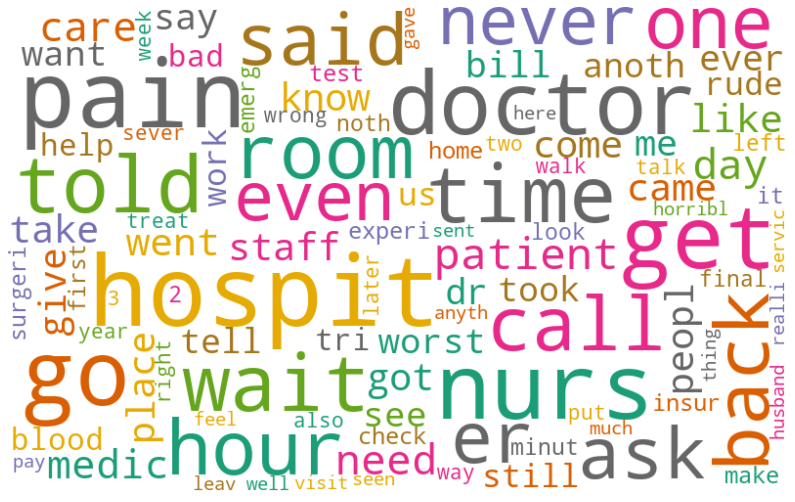

In [113]:
#Creating a word cloud for most common negative words
wordcloudConvertDF = negFreqDataFrame.set_index('Words').T.to_dict('records')
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=100, relative_scaling=0.5, colormap='Dark2', background_color='white').generate_from_frequencies(dict(*wordcloudConvertDF))

plt.figure(figsize=(14, 10))    
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [123]:
#Fetching top 100 most common positive words
from collections import Counter

positive_review = analyze_df[analyze_df.sentiment == "Positive"]

mostCommonPosWords = Counter(" ".join(positive_review["review"]).split()).most_common(100)

In [115]:
#Converting into dataframe
posFreqDataFrame = pd.DataFrame(list(mostCommonPosWords), columns=["Words", "Frequency"])

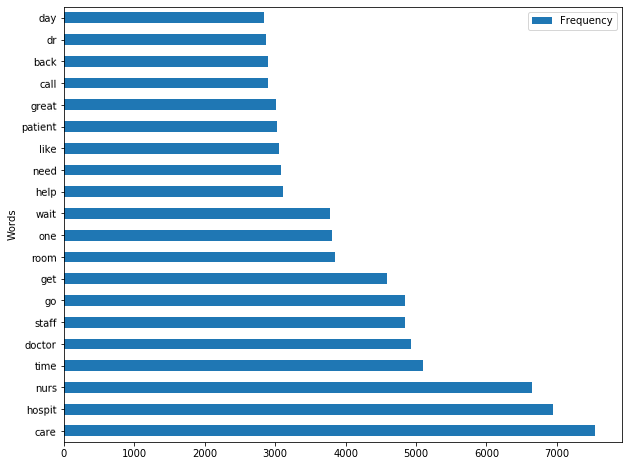

In [116]:
#Ploting horizontal bar graph for the top 20 most common positive words
posFreqDataFrame.head(20).plot.barh(x='Words', y='Frequency', rot=1, figsize=(10,8))

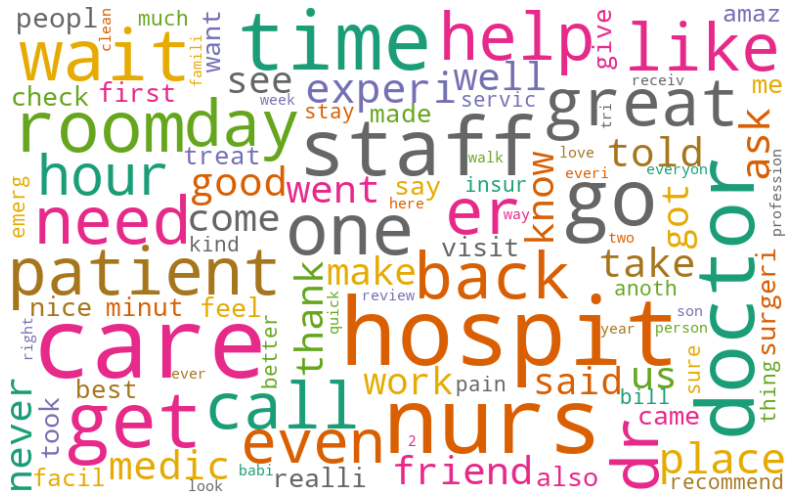

In [117]:
#Creating a word cloud for most common positive words
wordcloudConvertDF = posFreqDataFrame.set_index('Words').T.to_dict('records')
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=100, relative_scaling=0.5, colormap='Dark2', background_color='white').generate_from_frequencies(dict(*wordcloudConvertDF))

plt.figure(figsize=(14, 10))    
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()